# PyTorch Tutorial 04. The very first classifier

- 基本的に，[このチュートリアル](https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html)の内容に基づいている．  


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## 1. Prepare training dataset 

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## load TRAINING set
trainset = torchvision.datasets.CIFAR10(root='~/.cache/torch/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

## declare classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


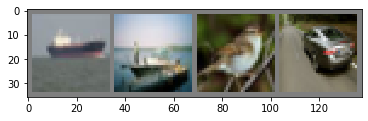

 ship  ship  bird   car


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## pick images randomly
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images & its labels in CIFAR-10 dataset
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define neural network

- パディング(padding)がないため，畳み込みによって画像が小さくなる点に注意

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  ## 3-channels (RGB) -> 6-channels 5x5 conv
        self.pool  = nn.MaxPool2d(2, 2)  ## max pooling in 2x2
        self.conv2 = nn.Conv2d(6, 16, 5) ## 6-channels -> 16 channels, with 5x5 conv
        
        self.fc1 = nn.Linear(16 * 5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) ## 32x32x3 -(conv5x5)-> 28x28x6 -(maxpool)-> 14x14x6
        x = self.pool(F.relu(self.conv2(x))) ## 14x14x6 -(conv5x5)-> 10x10x16 -(maxpool)-> 5x5x16
        x = x.view(-1, 16 * 5 * 5)           ## flattening as 5x5x16
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## 3. Training Neural Network

- Loss function: 分類(Classification)問題なので，交差エントロピー(cross-entropy)を用いる．
- Optimizer: 最適化にはSGD(Stochastic Gradient Descent)，それにmomentum値も用いる．

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
from tqdm.notebook import tqdm ## show progress in Jupyter notebook

epochs = 2

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader), 0):
        inputs, labels = data

        # zeroclear
        optimizer.zero_grad()

        # feed-forward, backprop & optimization
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # show loss per 2000 mini-batches
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.228
[1,  4000] loss: 1.905
[1,  6000] loss: 1.693
[1,  8000] loss: 1.602
[1, 10000] loss: 1.537
[1, 12000] loss: 1.487



[2,  2000] loss: 1.397
[2,  4000] loss: 1.393
[2,  6000] loss: 1.357
[2,  8000] loss: 1.337
[2, 10000] loss: 1.308
[2, 12000] loss: 1.312

Finished Training


In [7]:
PATH = './data/cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 4. Testing & Validation


In [8]:
## clear network & load data
net = Net()
PATH = './data/cifar_net.pth'
net.load_state_dict(torch.load(PATH)) ## once you get the trained data, you can start from here ...

<All keys matched successfully>

In [9]:
## load TESTING set
testset = torchvision.datasets.CIFAR10(root='~/.cache/torch/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


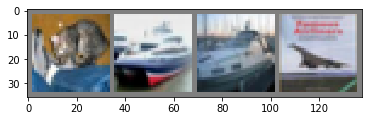

GroundTruth	:    cat  ship  ship plane
Predicted	:    cat  ship  ship plane


In [10]:
## pick 1 batch from testset
dataiter = iter(testloader)
images, labels = dataiter.next()

## show image & ground-truth label
imshow(torchvision.utils.make_grid(images))
print('GroundTruth\t: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(images))))

## feedforward 1 batch & predicted label
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted\t: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(images.shape[0])))

In [11]:
from datetime import datetime

start_time = datetime.now()

class_correct = [0.0] * 10
class_total   = [0.0] * 10
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range( len(images) ):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

elapsed_time = datetime.now() - start_time
print(elapsed_time)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

0:00:05.306392
Accuracy of plane : 62 %
Accuracy of   car : 66 %
Accuracy of  bird : 33 %
Accuracy of   cat : 46 %
Accuracy of  deer : 48 %
Accuracy of   dog : 29 %
Accuracy of  frog : 71 %
Accuracy of horse : 69 %
Accuracy of  ship : 67 %
Accuracy of truck : 54 %


## Validation on GPU

- 以下のコードはCUDA GPUでなければ作動しないことに注意．
- ネットワークが小さいため，速度の向上は見られない（むしろ遅くなる）．

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
from datetime import datetime

batch_size = 768
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

net.to(device) ## send network to GPU

start_time = datetime.now()

class_correct = [0.0] * 10
class_total   = [0.0] * 10
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) ## send data to GPU
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(len(images)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

elapsed_time = datetime.now() - start_time
print(elapsed_time)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

0:00:06.591999
Accuracy of plane : 62 %
Accuracy of   car : 66 %
Accuracy of  bird : 33 %
Accuracy of   cat : 46 %
Accuracy of  deer : 48 %
Accuracy of   dog : 29 %
Accuracy of  frog : 71 %
Accuracy of horse : 69 %
Accuracy of  ship : 67 %
Accuracy of truck : 54 %


(end)